# spectral profile extraction

In [1]:
# Import python modules

import matplotlib.pyplot as plt
from spectral.io import envi
import numpy as np
from pyproj import Proj
import os
from osgeo import gdal

## Define points of interest

In [13]:
# let's define the coordinates and data file from which we'll extract spectra and the lat/lon coordinates
data_file = 'data/AVIRIS_L3/ang20231126t084422_002_L2A_OE_main_27577724_RFL_ORT'
coords1 = [-33.95142512, 18.45648475] # GBIF Point
coords2 = [-33.951703  , 18.456484  ] # Relative Height of 5.06m in LiDAR
coords3 = [-33.951705  , 18.456406  ] # Relative Height of 6.54m in LiDAR
coords4 = [-33.9517    , 18.456398  ] # Relative Height of 9.35m in LiDAR
coords5 = [-33.951629  , 18.456402  ] # Relative Height of 4.72m in LiDAR
coords6 = [-33.951646  , 18.456372  ] # Relative Height of 7.34m in LiDAR
coords7 = [-33.951439  , 18.45649   ] # Relative Height of 2.02m in LiDAR
coords8 = [-33.951523  , 18.456394  ] # Relative Height of 1.95m in LiDAR

## Converting geographic coordinates to raster indices

In [12]:
# step to convert coordinates from EPSG: 4326 to EPSG:32734

from pyproj import Proj
p = Proj("EPSG:32734", preserve_units=False)
x,y = p(18.456394, -33.951523)
print('x value in UTM meters:', x)
print('y value in UTM meters:', y)

x value in UTM meters: 264940.87230738066
y value in UTM meters: 6240303.878502582


## EPSG:32734 - WGS-84 / UTM zone 34S

In [14]:
coords_UTM1 = [6240314.943327792, 264948.99141540634] # GBIF Point
coords_UTM2 = [6240284.119557253, 264949.6867668701 ] # Relative Height of 5.06m in LiDAR
coords_UTM3 = [6240283.7188432515, 264942.4823732481] # Relative Height of 6.54m in LiDAR
coords_UTM4 = [6240284.255089439, 264941.72913694347] # Relative Height of 9.35m in LiDAR
coords_UTM5 = [6240292.13948112 , 264941.90348876815] # Relative Height of 4.72m in LiDAR
coords_UTM6 = [6240290.185065158, 264939.1772320369 ] # Relative Height of 7.34m in LiDAR
coords_UTM7 = [6240313.415817692, 264949.5148936757 ] # Relative Height of 2.02m in LiDAR
coords_UTM8 = [6240303.878502582, 264940.87230738066] # Relative Height of 1.95m in LiDAR

## Accessing the dataset’s projection

In [15]:
gdal_ds = gdal.Open(data_file)
proj_native = gdal_ds.GetProjection()
proj_native

C:\Users\PC\anaconda3\envs\bioscape_py\Lib\site-packages\osgeo\gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",21],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

## Understanding the GeoTransform coefficients

In [16]:
trans = gdal_ds.GetGeoTransform() # x_ul, x_px, x_rot, y_ul, y_rot, y_px
print('\nGetGeoTransform Return Values =', trans) 


GetGeoTransform Return Values = (263929.7772268808, 1.9, 0.0, 6240865.50751282, 0.0, -1.9)


## Verifying coordinate extents

In [22]:
# Check to see if coordinates fit into grid
from osgeo import gdal
import numpy as np

ds = gdal.Open('data/AVIRIS_L3/ang20231126t084422_002_L2A_OE_main_27577724_RFL_ORT')
gt = ds.GetGeoTransform()  # (x_ul, x_px, 0, y_ul, 0, y_px_neg)
nx, ny = ds.RasterXSize, ds.RasterYSize

xmin = gt[0]
xmax = gt[0] + nx*gt[1]
ymax = gt[3]
ymin = gt[3] + ny*gt[5]   # gt[5] < 0

def inside(e, n):
    return (xmin <= e <= xmax) and (ymin <= n <= ymax)

print("extent E:", (xmin, xmax))
print("extent N:", (ymin, ymax))
print("target inside?", inside(264940.87230738066, 6240303.878502582))

extent E: (263929.7772268808, 265360.4772268808)
extent N: (6239879.40751282, 6240865.50751282)
target inside? True


## Computing pixel offsets
x,y offset values are a position on the x,y grid of the pixel of interest

In [23]:
# First coordinate

x_px_offset1 = int(round((coords_UTM1[1] - trans[0]) / trans[1]))
y_px_offset1 = int(round((coords_UTM1[0] - trans[3]) / trans[5]))

print(x_px_offset1, y_px_offset1)

536 290


In [24]:
# Second coordinate

x_px_offset2 = int(round((coords_UTM2[1] - trans[0]) / trans[1]))
y_px_offset2 = int(round((coords_UTM2[0] - trans[3]) / trans[5]))

print(x_px_offset2, y_px_offset2)

537 306


In [25]:
# Third coordinate

x_px_offset3 = int(round((coords_UTM3[1] - trans[0]) / trans[1]))
y_px_offset3 = int(round((coords_UTM3[0] - trans[3]) / trans[5]))

print(x_px_offset3, y_px_offset3)

533 306


In [26]:
# Fourth coordinate

x_px_offset4 = int(round((coords_UTM4[1] - trans[0]) / trans[1]))
y_px_offset4 = int(round((coords_UTM4[0] - trans[3]) / trans[5]))

print(x_px_offset4, y_px_offset4)

533 306


In [27]:
# Fifth coordinate

x_px_offset5 = int(round((coords_UTM5[1] - trans[0]) / trans[1]))
y_px_offset5= int(round((coords_UTM5[0] - trans[3]) / trans[5]))

print(x_px_offset5, y_px_offset5)

533 302


In [28]:
# Sixth coordinate

x_px_offset6 = int(round((coords_UTM6[1] - trans[0]) / trans[1]))
y_px_offset6 = int(round((coords_UTM6[0] - trans[3]) / trans[5]))

print(x_px_offset6, y_px_offset6)

531 303


In [29]:
# Seventh coordinate

x_px_offset7 = int(round((coords_UTM7[1] - trans[0]) / trans[1]))
y_px_offset7 = int(round((coords_UTM7[0] - trans[3]) / trans[5]))

print(x_px_offset7, y_px_offset7)

537 291


In [30]:
# Eighth coordinate

x_px_offset8 = int(round((coords_UTM8[1] - trans[0]) / trans[1]))
y_px_offset8 = int(round((coords_UTM8[0] - trans[3]) / trans[5]))

print(x_px_offset8, y_px_offset8)

532 296


## Extracting spectral windows and comparing locations

In [31]:
# Open ENVI file with `spectral.io`

ds = envi.open(os.path.splitext(data_file)[0] + '.hdr')
ds

	Data Source:   '.\data/AVIRIS_L3/ang20231126t084422_002_L2A_OE_main_27577724_RFL_ORT'
	# Rows:            519
	# Samples:         753
	# Bands:           425
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32

#### Extract 2x2 pixel windows around each point

In [33]:
# First coordinate

offset_size = 1
data1 = ds.open_memmap(interleave='bip')[y_px_offset1 - 1: y_px_offset1 + 1, x_px_offset1 - 1: x_px_offset1 + 1, :]
data1

memmap([[[-0.01      ,  0.03707601,  0.04295188, ...,  0.19872165,
           0.24510108, -0.01      ],
         [-0.01      ,  0.03692579,  0.04197193, ...,  0.22793618,
           0.33457184, -0.01      ]],

        [[-0.01      ,  0.02514842,  0.02510792, ...,  0.09924927,
           0.10194463, -0.01      ],
         [-0.01      ,  0.03427705,  0.03499448, ...,  0.16357456,
           0.16408338, -0.01      ]]], shape=(2, 2, 425), dtype=float32)

In [34]:
# Second coordinate

offset_size = 1
data2 = ds.open_memmap(interleave='bip')[y_px_offset2 - 1: y_px_offset2 + 1, x_px_offset2 - 1: x_px_offset2 + 1, :]
data2

memmap([[[-0.01      ,  0.01836294,  0.01860571, ...,  0.05504008,
           0.05588963, -0.01      ],
         [-0.01      ,  0.02245327,  0.02166517, ...,  0.05095081,
           0.05340336, -0.01      ]],

        [[-0.01      ,  0.02147327,  0.02039151, ...,  0.05977523,
           0.05934378, -0.01      ],
         [-0.01      ,  0.02420501,  0.02385452, ...,  0.056383  ,
           0.05807087, -0.01      ]]], shape=(2, 2, 425), dtype=float32)

In [35]:
# Third coordinate

offset_size = 1
data3 = ds.open_memmap(interleave='bip')[y_px_offset3 - 1: y_px_offset3 + 1, x_px_offset3 - 1: x_px_offset3 + 1, :]
data3

memmap([[[-0.01      ,  0.02922182,  0.02592635, ...,  0.07920974,
           0.08063766, -0.01      ],
         [-0.01      ,  0.02913214,  0.03063711, ...,  0.09518069,
           0.09806516, -0.01      ]],

        [[-0.01      ,  0.02540617,  0.02451351, ...,  0.07847264,
           0.08103292, -0.01      ],
         [-0.01      ,  0.02548181,  0.02675545, ...,  0.07117745,
           0.07237375, -0.01      ]]], shape=(2, 2, 425), dtype=float32)

In [36]:
# Fourth coordinate

offset_size = 1
data4 = ds.open_memmap(interleave='bip')[y_px_offset4 - 1: y_px_offset4 + 1, x_px_offset4 - 1: x_px_offset4 + 1, :]
data4

memmap([[[-0.01      ,  0.02922182,  0.02592635, ...,  0.07920974,
           0.08063766, -0.01      ],
         [-0.01      ,  0.02913214,  0.03063711, ...,  0.09518069,
           0.09806516, -0.01      ]],

        [[-0.01      ,  0.02540617,  0.02451351, ...,  0.07847264,
           0.08103292, -0.01      ],
         [-0.01      ,  0.02548181,  0.02675545, ...,  0.07117745,
           0.07237375, -0.01      ]]], shape=(2, 2, 425), dtype=float32)

In [37]:
# Fifth coordinate

offset_size = 1
data5 = ds.open_memmap(interleave='bip')[y_px_offset5 - 1: y_px_offset5 + 1, x_px_offset5 - 1: x_px_offset5 + 1, :]
data5

memmap([[[-0.01      ,  0.02025629,  0.02056011, ...,  0.04459881,
           0.04636716, -0.01      ],
         [-0.01      ,  0.0203638 ,  0.02056666, ...,  0.05722727,
           0.05963761, -0.01      ]],

        [[-0.01      ,  0.01868852,  0.02006682, ...,  0.04191463,
           0.0426888 , -0.01      ],
         [-0.01      ,  0.01819296,  0.01835022, ...,  0.05263972,
           0.05516333, -0.01      ]]], shape=(2, 2, 425), dtype=float32)

In [38]:
# Sixth coordinate

offset_size = 1
data6 = ds.open_memmap(interleave='bip')[y_px_offset6 - 1: y_px_offset6 + 1, x_px_offset6 - 1: x_px_offset6 + 1, :]
data6

memmap([[[-0.01      ,  0.01904821,  0.02008853, ...,  0.0567989 ,
           0.06037552, -0.01      ],
         [-0.01      ,  0.0167045 ,  0.01462151, ...,  0.05410047,
           0.0571468 , -0.01      ]],

        [[-0.01      ,  0.02202058,  0.02037332, ...,  0.05464209,
           0.05756249, -0.01      ],
         [-0.01      ,  0.01702579,  0.01719248, ...,  0.05837688,
           0.0615562 , -0.01      ]]], shape=(2, 2, 425), dtype=float32)

In [39]:
# Seventh coordinate

offset_size = 1
data7 = ds.open_memmap(interleave='bip')[y_px_offset7 - 1: y_px_offset7 + 1, x_px_offset7 - 1: x_px_offset7 + 1, :]
data7

memmap([[[-0.01      ,  0.03427705,  0.03499448, ...,  0.16357456,
           0.16408338, -0.01      ],
         [-0.01      ,  0.03064998,  0.03622249, ...,  0.23559216,
           0.2873541 , -0.01      ]],

        [[-0.01      ,  0.03047153,  0.03165581, ...,  0.10662285,
           0.10597302, -0.01      ],
         [-0.01      ,  0.03380144,  0.03568966, ...,  0.27566898,
           0.26889062, -0.01      ]]], shape=(2, 2, 425), dtype=float32)

In [40]:
# Eighth coordinate

offset_size = 1
data8 = ds.open_memmap(interleave='bip')[y_px_offset8 - 1: y_px_offset8 + 1, x_px_offset8 - 1: x_px_offset8 + 1, :]
data8

memmap([[[-0.01      ,  0.02368926,  0.02413774, ...,  0.05928755,
           0.06093521, -0.01      ],
         [-0.01      ,  0.02159707,  0.01994051, ...,  0.0484022 ,
           0.04953958, -0.01      ]],

        [[-0.01      ,  0.02266854,  0.02374971, ...,  0.05594222,
           0.05850077, -0.01      ],
         [-0.01      ,  0.02388209,  0.02195598, ...,  0.04973185,
           0.05144657, -0.01      ]]], shape=(2, 2, 425), dtype=float32)

## Plotting mean spectra (GBIF Point only)

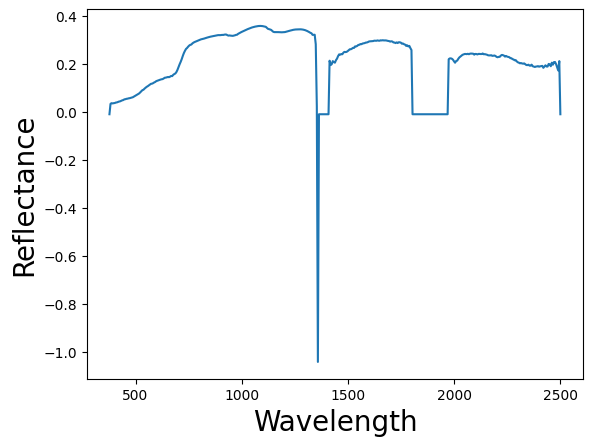

In [41]:
wl1 = np.array([float(x) for x in ds.metadata['wavelength']])
wl2 = np.array([float(x) for x in ds.metadata['wavelength']])
wl3 = np.array([float(x) for x in ds.metadata['wavelength']])
wl4 = np.array([float(x) for x in ds.metadata['wavelength']])
wl5 = np.array([float(x) for x in ds.metadata['wavelength']])
wl6 = np.array([float(x) for x in ds.metadata['wavelength']])
wl7 = np.array([float(x) for x in ds.metadata['wavelength']])
wl8 = np.array([float(x) for x in ds.metadata['wavelength']])

plt.plot(wl1, np.mean(data1, axis=(0, 1)))
plt.rcParams['figure.figsize'] = [8, 8]
plt.xlabel('Wavelength', fontsize=20)
plt.ylabel('Reflectance', fontsize=20)
plt.show()

The above spectral profile still has some bad band to it which have not been removed as of yet. That is the reason behind the reflectance values sharply falling towards/below zero. In order to get a good profile, I will have to remove the bad bands that are written in the header file of this cube.

## Defining manual bad band list

In [42]:
# Define a list of wavelengths that are "bad" 
# These bad band values were taken from the header file.

bblist = np.ones((425,))  # create a 1D array with values ones
# set tails and atmospheric window to zero
bblist[0:0] = 0         # tail
bblist[197:206] = 0     # atmospheric window
bblist[285:318] = 0     # atmospheric window
bblist[424:424] = 0     # tail

## Plot masked spectral profile (Bad bands removed)

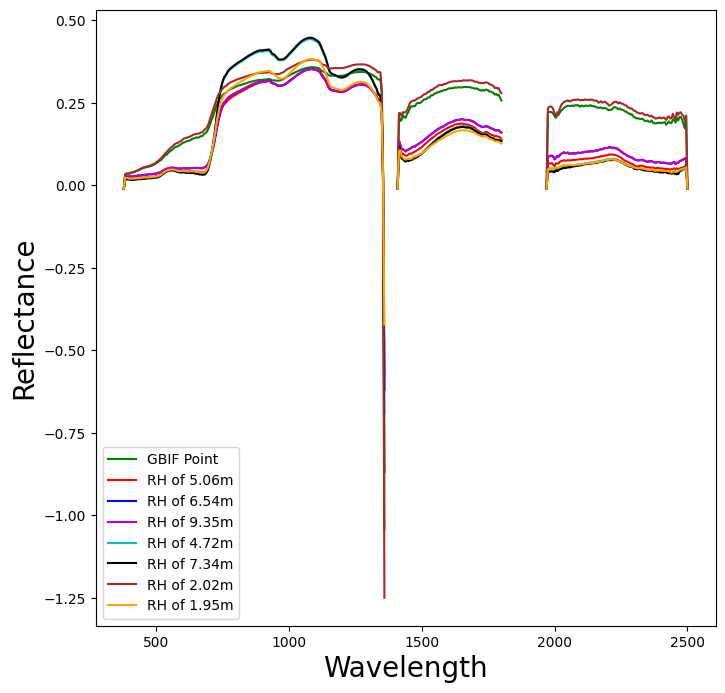

In [44]:
plt.rcParams['figure.figsize'] = [8, 8]

wl1[bblist == 0] = np.nan 
wl2[bblist == 0] = np.nan
wl3[bblist == 0] = np.nan
wl4[bblist == 0] = np.nan
wl5[bblist == 0] = np.nan
wl6[bblist == 0] = np.nan
wl7[bblist == 0] = np.nan
wl8[bblist == 0] = np.nan

plt.plot(wl1, np.mean(data1, axis=(0, 1)), color = 'g', label = "GBIF Point")
plt.plot(wl2, np.mean(data2, axis=(0, 1)), color = 'r', label = "RH of 5.06m")
plt.plot(wl3, np.mean(data3, axis=(0, 1)), color = 'b', label = "RH of 6.54m")
plt.plot(wl4, np.mean(data4, axis=(0, 1)), color = 'm', label = "RH of 9.35m")
plt.plot(wl5, np.mean(data5, axis=(0, 1)), color = 'c', label = "RH of 4.72m")
plt.plot(wl6, np.mean(data6, axis=(0, 1)), color = 'k', label = "RH of 7.34m")
plt.plot(wl7, np.mean(data7, axis=(0, 1)), color = 'brown', label = "RH of 2.02m")
plt.plot(wl8, np.mean(data8, axis=(0, 1)), color = 'orange', label = "RH of 1.95m")

plt.xlabel('Wavelength', fontsize=20)
plt.ylabel('Reflectance', fontsize=20)
plt.legend()
plt.show()

# Interactive Plot
Let us try to make an interactive plot. One where we can zoom in and out and possibly show two spectral images for comparisons

## Import python modules

In [69]:
import panel as pn; pn.extension()
import numpy as np
import pandas as pd
import hvplot.pandas

In [77]:
# Load BBL from ENVI header
def _parse_envi_list(val):
    """
    ENVI header fields like 'wavelength' or 'bbl' can be:
      - list-like already (list/tuple),
      - a string with braces/slashes/commas/spaces.
    Return a 1D np.ndarray of floats.
    """
    if val is None:
        return None
    if isinstance(val, (list, tuple, np.ndarray)):
        return np.asarray(val, dtype=float).ravel()
    if isinstance(val, str):
        s = val.strip()
        # strip braces and common delimiters
        for ch in "{}[]()":
            s = s.replace(ch, " ")
        s = s.replace(",", " ").replace(";", " ")
        toks = [t for t in s.split() if t]
        return np.asarray([float(t) for t in toks], dtype=float)
    raise TypeError(f"Unsupported ENVI value type for parsing: {type(val)}")

def load_bbl_from_hdr(hdr_path, expected_bands=None):
    """
    Read 'bbl' from an ENVI .hdr. Returns a boolean keep-mask (True = good band).
    If expected_bands is given, validate length; if mismatched, truncate or pad with 1s (conservative).
    """
    meta = envi.read_envi_header(hdr_path)  # small, fast
    bbl_raw = meta.get("bbl", None)
    if bbl_raw is None:
        raise RuntimeError(f"No 'bbl' field found in header: {hdr_path}")
    bbl = _parse_envi_list(bbl_raw)

    # ENVI sometimes stores 0/1; sometimes >0 meaning “good”. Treat >0 as keep.
    keep = np.asarray(bbl, dtype=float) > 0

    # Validate length
    hdr_bands = int(meta.get("bands", keep.size))
    if expected_bands is None:
        expected_bands = hdr_bands

    if keep.size < expected_bands:
        # Pad tail with True (keep) — conservative; you can tighten if you know tails are bad
        pad = np.ones(expected_bands - keep.size, dtype=bool)
        keep = np.concatenate([keep, pad])
    elif keep.size > expected_bands:
        keep = keep[:expected_bands]

    return keep

# Point this to any AVIRIS-NG reflectance header from the same sensor product as your cubes
hdr_path = "data/AVIRIS_L3/ang20231126t084422_002_L2A_OE_main_27577724_RFL_ORT.hdr"

# Infer the “canonical” band count from your arrays (they should all agree)
band_counts = [np.asarray(d).shape[-1] for d in (data1, data2, data3, data4, data5, data6, data7, data8)]
nb = int(np.median(band_counts))  # tolerant if one is off by 1
bb_keep = load_bbl_from_hdr(hdr_path, expected_bands=nb)  # True = good band

In [71]:
# Place inputs into a dictionary: keys -> legend names; values -> (wavelengths, data_cube)
spectra_inputs = {
    "GBIF Point": (wl1, data1),
    "RH of 5.06m": (wl2, data2),
    "RH of 6.54m": (wl3, data3),
    "RH of 9.35m": (wl4, data4),
    "RH of 4.72m": (wl5, data5),
    "RH of 7.34m": (wl6, data6),
    "RH of 2.02m": (wl7, data7),
    "RH of 1.95m": (wl8, data8),
}

In [78]:
# Construct a tidy DataFrame from arrays

def mean_profile(cube):
    # AVIRIS cubes: (rows, cols, bands)
    return np.nanmean(cube, axis=(0, 1))

def build_df(use_bbl=True, normalise=False):
    recs = []
    for obs_id, (wl, cube) in spectra_inputs.items():
        wl = np.asarray(wl).ravel()
        y  = np.asarray(mean_profile(cube)).ravel()

        # Align to the common length/bbl
        n = min(len(wl), len(y), len(bb_keep))
        wl = wl[:n]
        y  = y[:n]
        keep = bb_keep[:n] if use_bbl else np.ones(n, dtype=bool)

        # Mask *reflectance* at bad bands
        y_masked = np.where(keep, y, np.nan)

        if normalise:
            denom = np.nanmax(np.abs(y_masked))
            if np.isfinite(denom) and denom > 0:
                y_masked = y_masked / denom

        recs.append(pd.DataFrame({"obs_id": obs_id,
                                  "wavelength_nm": wl,
                                  "reflectance": y_masked}))
    return pd.concat(recs, ignore_index=True)

In [81]:
# Widgets
pick = pn.widgets.MultiChoice(
    name="Compare up to 8 spectra",
    options=list(spectra_inputs.keys()),
    value=["GBIF Point"]
)
norm = pn.widgets.Checkbox(name="Normalise each spectrum to its max", value=False)
mask_bad = pn.widgets.Checkbox(name="Hide bad bands (HDR bbl → NaN)", value=True)

@pn.depends(pick, watch=True)
def _cap_selection(_):
    if len(pick.value) > 2:
        pick.value = list(pick.value)[-8:]

def view(selected, normalise, use_mask):
    df_all   = build_df(use_bbl=use_mask, normalise=False)
    df_focus = build_df(use_bbl=use_mask, normalise=normalise)
    d = df_focus[df_focus["obs_id"].isin(selected)]

    tools = ["pan", "wheel_zoom", "box_zoom", "reset", "save"]
    ylabel = "Reflectance (normalised)" if normalise else "Reflectance"

    base = df_all.hvplot.line(
        x="wavelength_nm", y="reflectance", by="obs_id",
        alpha=0.15, line_width=1, legend=False,
        responsive=True, height=520, tools=tools
    )
    if d.empty:
        focus = df_all.iloc[0:0].hvplot.line(x="wavelength_nm", y="reflectance",
                                             responsive=True, height=520, tools=tools)
    else:
        focus = d.hvplot.line(
            x="wavelength_nm", y="reflectance", by="obs_id",
            line_width=2.5, responsive=True, height=520, tools=tools
        )
    return (base * focus).opts(
        xlabel="Wavelength (nm)", ylabel=ylabel, title="AVIRIS-NG Spectral Profiles (HDR BBL)"
    )

app = pn.Column(
    pn.Row(pick, norm, mask_bad),
    pn.bind(view, selected=pick, normalise=norm, use_mask=mask_bad)
)
app

Column
    [0] Row
        [0] MultiChoice(name='Compare up to 8 spectra', options=['GBIF Point', ...], value=['GBIF Point'])
        [1] Checkbox(name='Normalise each s...)
        [2] Checkbox(name='Hide bad bands (..., value=True)
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)